In [1]:
import os
import numpy as np
os.chdir("/Users/coulaud/Documents/DL-normalization")
os.getcwd()
data_dir = "data/processed/nemonemo_bnd_perten1_samples_standardize/"


In [26]:
def cropX(X, dist_map):
    _,H,W  = X.shape
    if H != 310 and W != 380:
        padd_H = (H-290)//2 - 10
        padd_W = (W-360)//2 - 10
        Y    = np.empty((4,310,380))
        Y[0] = X[0,padd_H:-padd_H,padd_W:-padd_W]
        Y[1] = X[1,padd_H:-padd_H,padd_W:-padd_W]
        Y[2] = X[2,padd_H:-padd_H,padd_W:-padd_W]
        Y[3] = dist_map
        return Y
    return X


def cropY(Y):
    H,W  = Y.shape
    if H != 310 and W != 380:
        padd_H = (H-290)//2 - 10
        padd_W = (W-360)//2 - 10
        Y = Y[padd_H:-padd_H,padd_W:-padd_W]
    return Y

def rota_90(X):
    _,H,W  = X.shape
      
    alphas_i = np.rot90(X[0,:,:], k=1, axes=(0,1))
    alphas_j = np.rot90(X[1,:,:], k=1, axes=(0,1))
    w        = np.rot90(X[2,:,:], k=1, axes=(0,1))
    dist_map = np.rot90(X[3,:,:], k=1, axes=(0,1))
    alphas_i = np.roll(alphas_i, -1, axis = 1)
    
    X    = np.empty((4,W,H))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    X[3] = dist_map
    return X

def rota_180(X):
    _,H,W  = X.shape

    
    
    alphas_i = np.rot90(X[0,:,:], k=2, axes=(0,1))
    alphas_j = np.rot90(X[1,:,:], k=2, axes=(0,1))
    w        = np.rot90(X[2,:,:], k=2, axes=(0,1))
    dist_map = np.rot90(X[3,:,:], k=2, axes=(0,1))
    alphas_j = np.roll(alphas_j, -1, axis = 1)
    alphas_i = np.roll(alphas_i, 1, axis = 0)
    
    X    = np.empty((4,H,W))
    X[0] = alphas_i
    X[1] = alphas_j
    X[2] = w
    X[3] = dist_map
    return X

def rota_270(X):
    _,H,W  = X.shape
        
    alphas_i = np.rot90(X[0,:,:], k=1, axes=(1,0))
    alphas_j = np.rot90(X[1,:,:], k=1, axes=(1,0))
    w        = np.rot90(X[2,:,:], k=1, axes=(1,0))
    dist_map = np.rot90(X[3,:,:], k=1, axes=(1,0))
    alphas_j = np.roll(alphas_j, 1, axis = 0)
    
    X    = np.empty((4,W,H))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    X[3] = dist_map
    return X

def flip_hor(X):
    _,H,W  = X.shape

    alphas_i = np.flipud(X[0,:,:])
    alphas_j = np.flipud(X[1,:,:])
    w        = np.flipud(X[2,:,:])
    dist_map = np.flipud(X[3,:,:])
    alphas_i = np.roll(alphas_i, 1, axis = 0)
    X    = np.empty((4,H,W))
    X[0] = alphas_i
    X[1] = alphas_j
    X[2] = w
    X[3] = dist_map
    return X

def flip_vert(X):
    _,H,W  = X.shape

    alphas_i = np.fliplr(X[0,:,:])
    alphas_j = np.fliplr(X[1,:,:])
    w        = np.fliplr(X[2,:,:])
    dist_map = np.fliplr(X[3,:,:])
    alphas_j = np.roll(alphas_j, -1, axis = 1)
    X    = np.empty((4,H,W))
    X[0] = alphas_i
    X[1] = alphas_j
    X[2] = w
    X[3] = dist_map
    return X

In [5]:
X = cropX(np.load(data_dir+"train/X/NORSSH_BND_PERTEN84.npz")['arr_0'], np.load("data/sign_distance_map_std.npy"))

In [27]:
np.array_equal(flip_hor(flip_vert(X)),flip_vert(flip_hor(X)))

True

In [7]:
np.array_equal(flip_vert(flip_hor(X)),rota_180(X))

True

In [8]:
np.array_equal(rota_180(rota_180(X)),X)

True

In [9]:
np.array_equal(rota_90(rota_90(X)),rota_180(X))

True

In [10]:
np.array_equal(rota_270(rota_270(X)),rota_180(X))

True

In [11]:
np.array_equal(rota_90(rota_180(X)),rota_270(X)), np.array_equal(rota_180(rota_90(X)),rota_270(X))

(True, True)

In [12]:
np.array_equal(rota_90(rota_90(rota_90(X))),rota_270(X))

True

In [13]:
np.array_equal(rota_90(rota_90(rota_90(rota_90(X)))),X)

True

In [14]:
np.array_equal(rota_270(rota_270(rota_270(rota_270(X)))),X)

True

In [15]:
np.array_equal(flip_vert(flip_hor(flip_vert(flip_hor(X)))),X)

True

In [18]:
np.array_equal(rota_90(rota_270(X)),rota_270(rota_90(X))), np.array_equal(rota_90(rota_270(X)),X), np.array_equal(X,rota_90(rota_270(X)))

(True, True, True)

In [29]:
import numpy as np
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import src.cnn_map as cnn_map
import torchvision.transforms as transforms
import importlib
import os
import matplotlib.pyplot as plt

f = open(data_dir+"norms_std_mean.txt")
lines = f.readlines()
assert len(lines) == 2, f"len {len(lines)}"
std = float(lines[0])
mean = float(lines[1])
f.close()
data_dir = "data/processed/nemonemo_bnd_perten1_samples_standardize/"
save_dir = "notebooks/map_comparison/"
size_im = (70, 40)
def transfrom(X):
    return transforms.CenterCrop([310, 380])(torch.from_numpy(X)).numpy()

X_train = cropX(np.load(data_dir+"train/X/NORSSH_BND_PERTEN84.npz")['arr_0'], np.load("data/sign_distance_map.npy"))
Y_train = cropY(np.load(data_dir+"train/Y/NORSSH_BND_PERTEN84_norm_coeffs.npz")['arr_0'])
X_valid = cropX(np.load(data_dir+"valid/X/NORSSH_BND_PERTEN199.npz")['arr_0'], np.load("data/sign_distance_map.npy"))
Y_valid = cropY(np.load(data_dir+"valid/Y/NORSSH_BND_PERTEN199_norm_coeffs.npz")['arr_0'])
distance_map = transfrom(np.load("data/sign_distance_map.npy"))
distance_map_std = (distance_map-np.mean(distance_map))/np.std(distance_map)

def compute_eps(X,Y, model_path,use_map=False,distance_map=None): 

    #if use_map :
        #X_map = np.empty((4,310,380))
        #X_map[0:3,:,:] = X
        #X_map[3,:,:] = distance_map
        #X = X_map
    model = cnn_map.CNN.load_from_checkpoint(model_path)  
        
    #else :
    #    model = cnn.CNN.load_from_checkpoint(model_path)   
    
    
    Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
    X = transforms.CenterCrop([310, 380])(torch.from_numpy(X[np.newaxis,:]).float())
    mask = np.where(Y==0,True,False)
    Y = Y*std + mean

    Y_pred = model.forward(X).detach()*std + mean
    Y_pred =  transforms.CenterCrop([290, 360])(Y_pred).numpy()[0,0,:,:]

    Y2 = np.power(Y,2)
    eps = (np.power(Y_pred,2) - Y2)/Y2
    eps = np.ma.masked_array(eps, mask)

    print("mean: ",np.mean(eps[np.nonzero(eps)]))
    print("max: ",np.max(eps))
    print("min: ",np.min(eps))
    
    return eps

/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mean:  0.013150903231700884
max:  1.8554688008396818
min:  -0.59559213655926


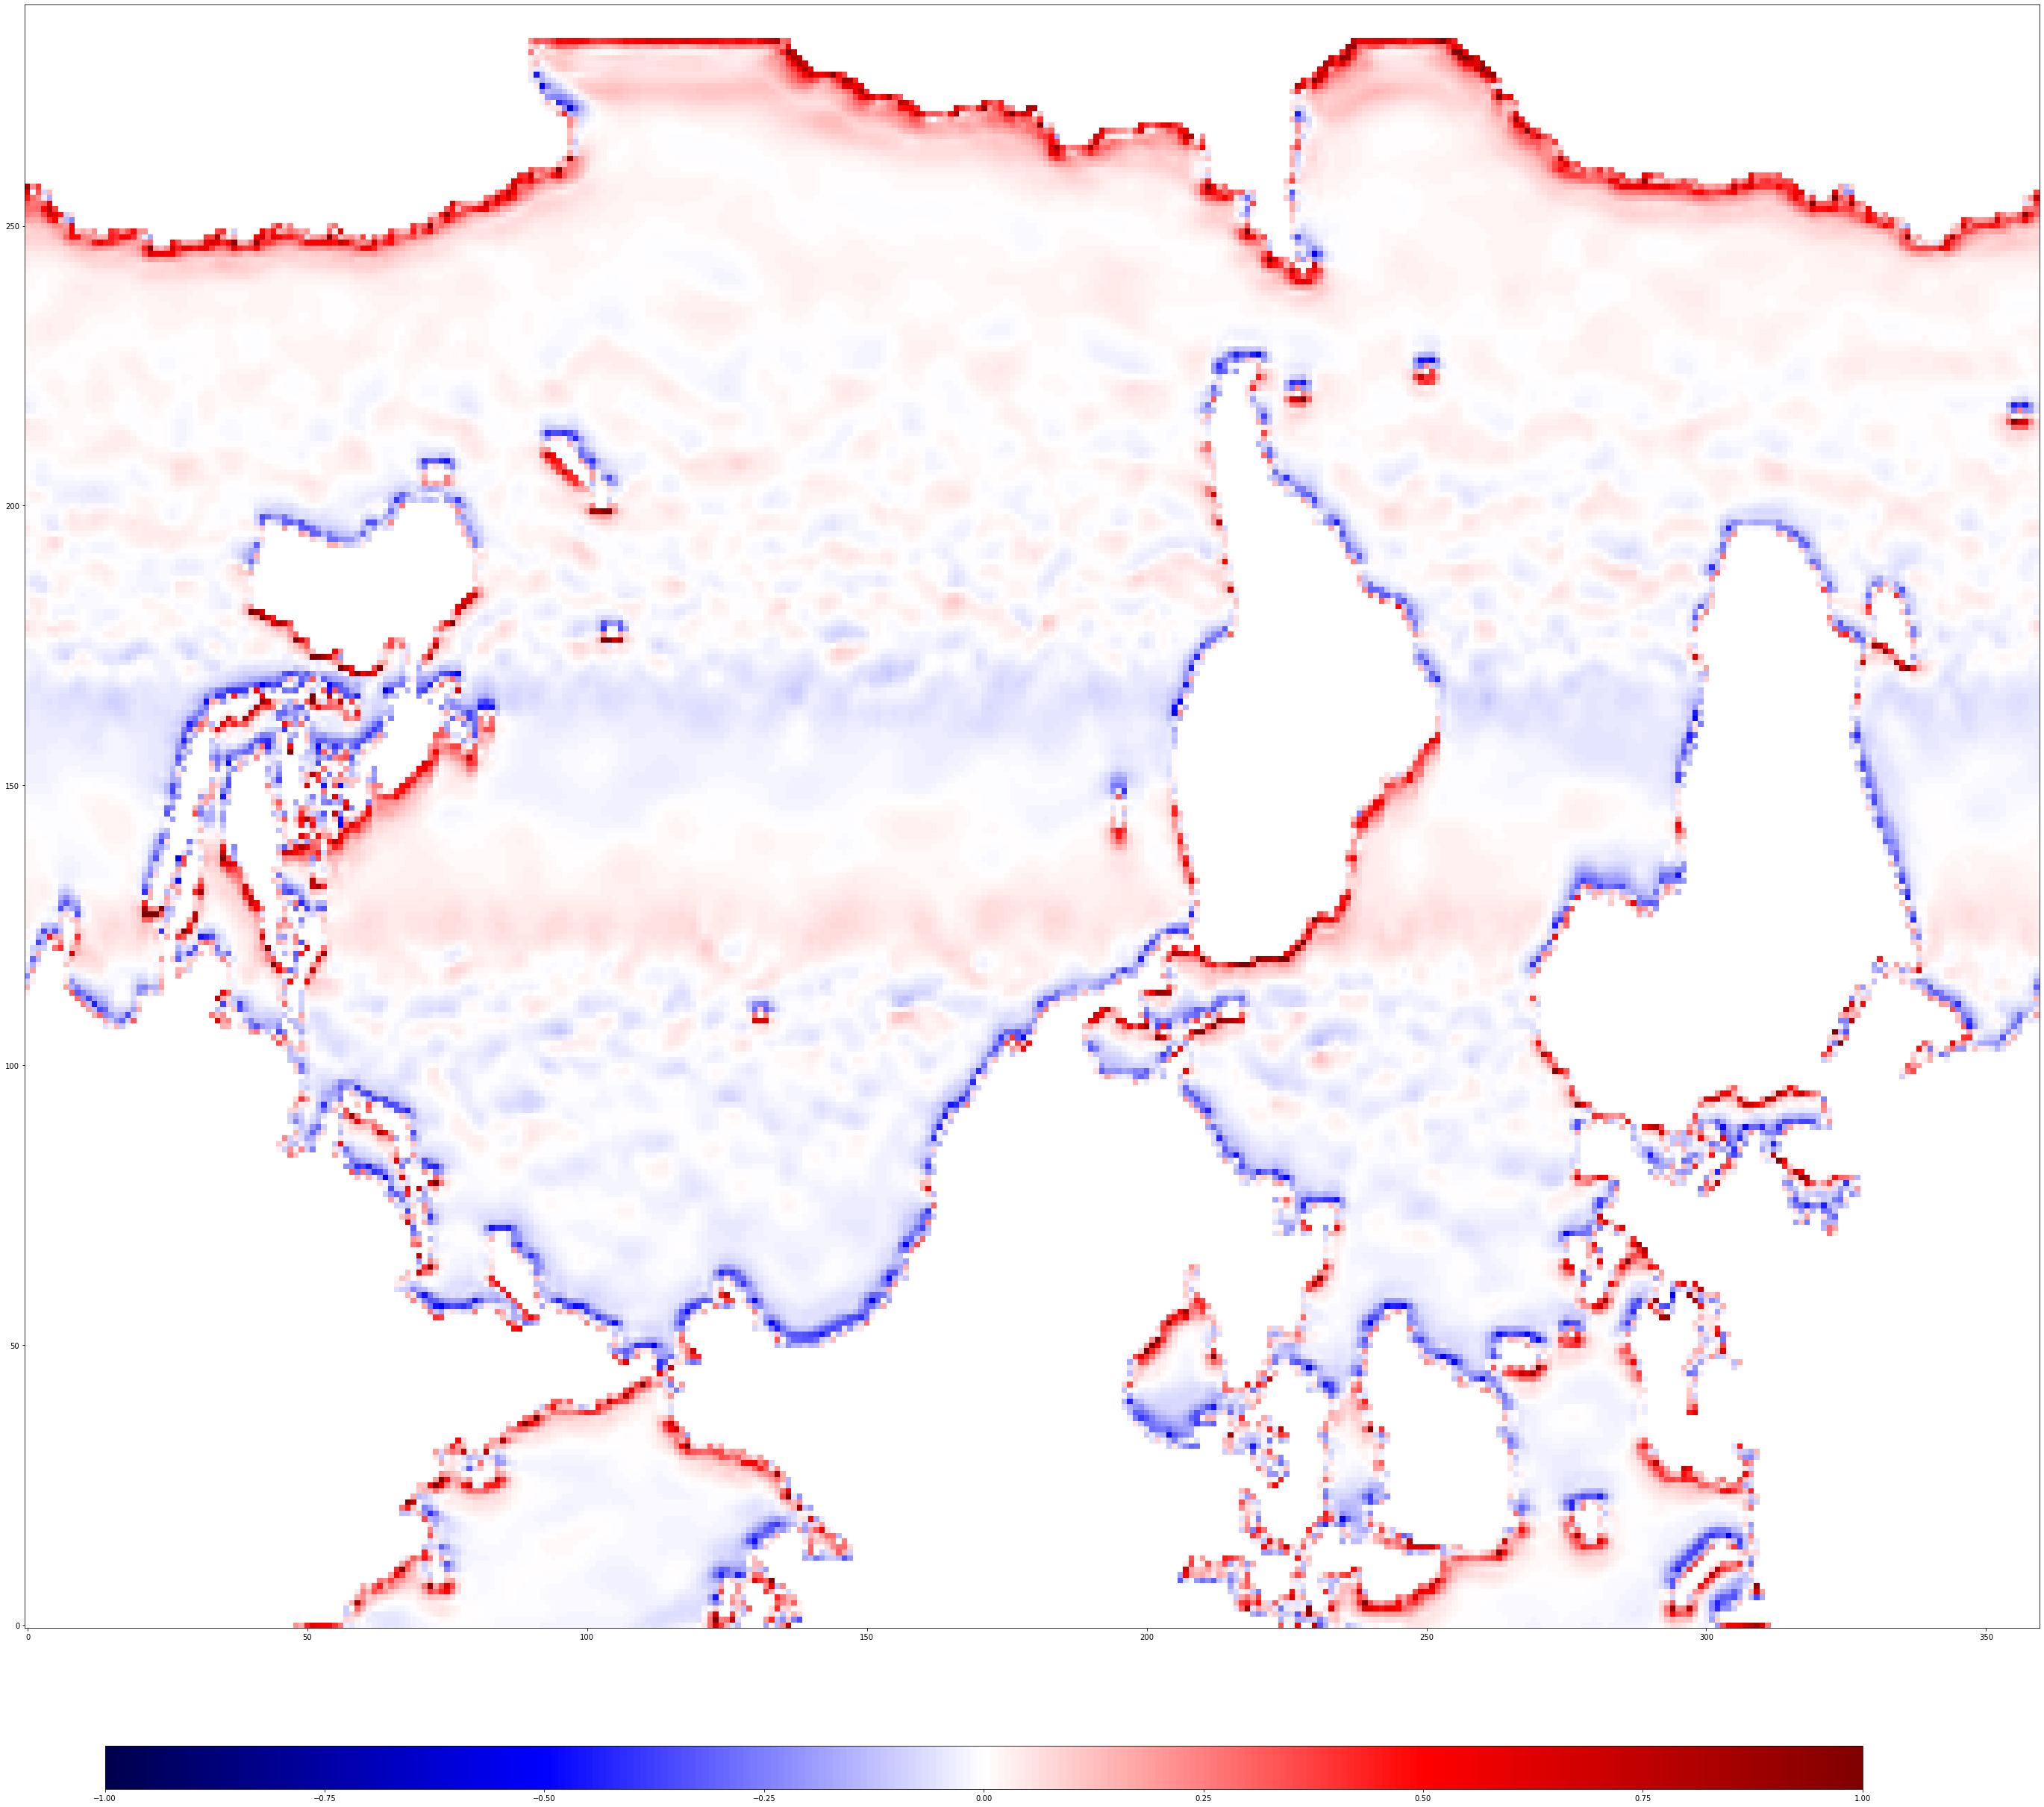

In [66]:
model_path = "results/wandb/cnn/1_1_adam_map/checkpoints/epoch=42198-val_loss=0.00018.ckpt"
X = flip_vert_V2(X_train).copy()
Y = np.flipud(Y_train).copy()
eps = compute_eps(X,Y,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-1,vmax=1,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

mean:  0.0012011105923108235
max:  1.5786810927317305
min:  -0.5654152102052317


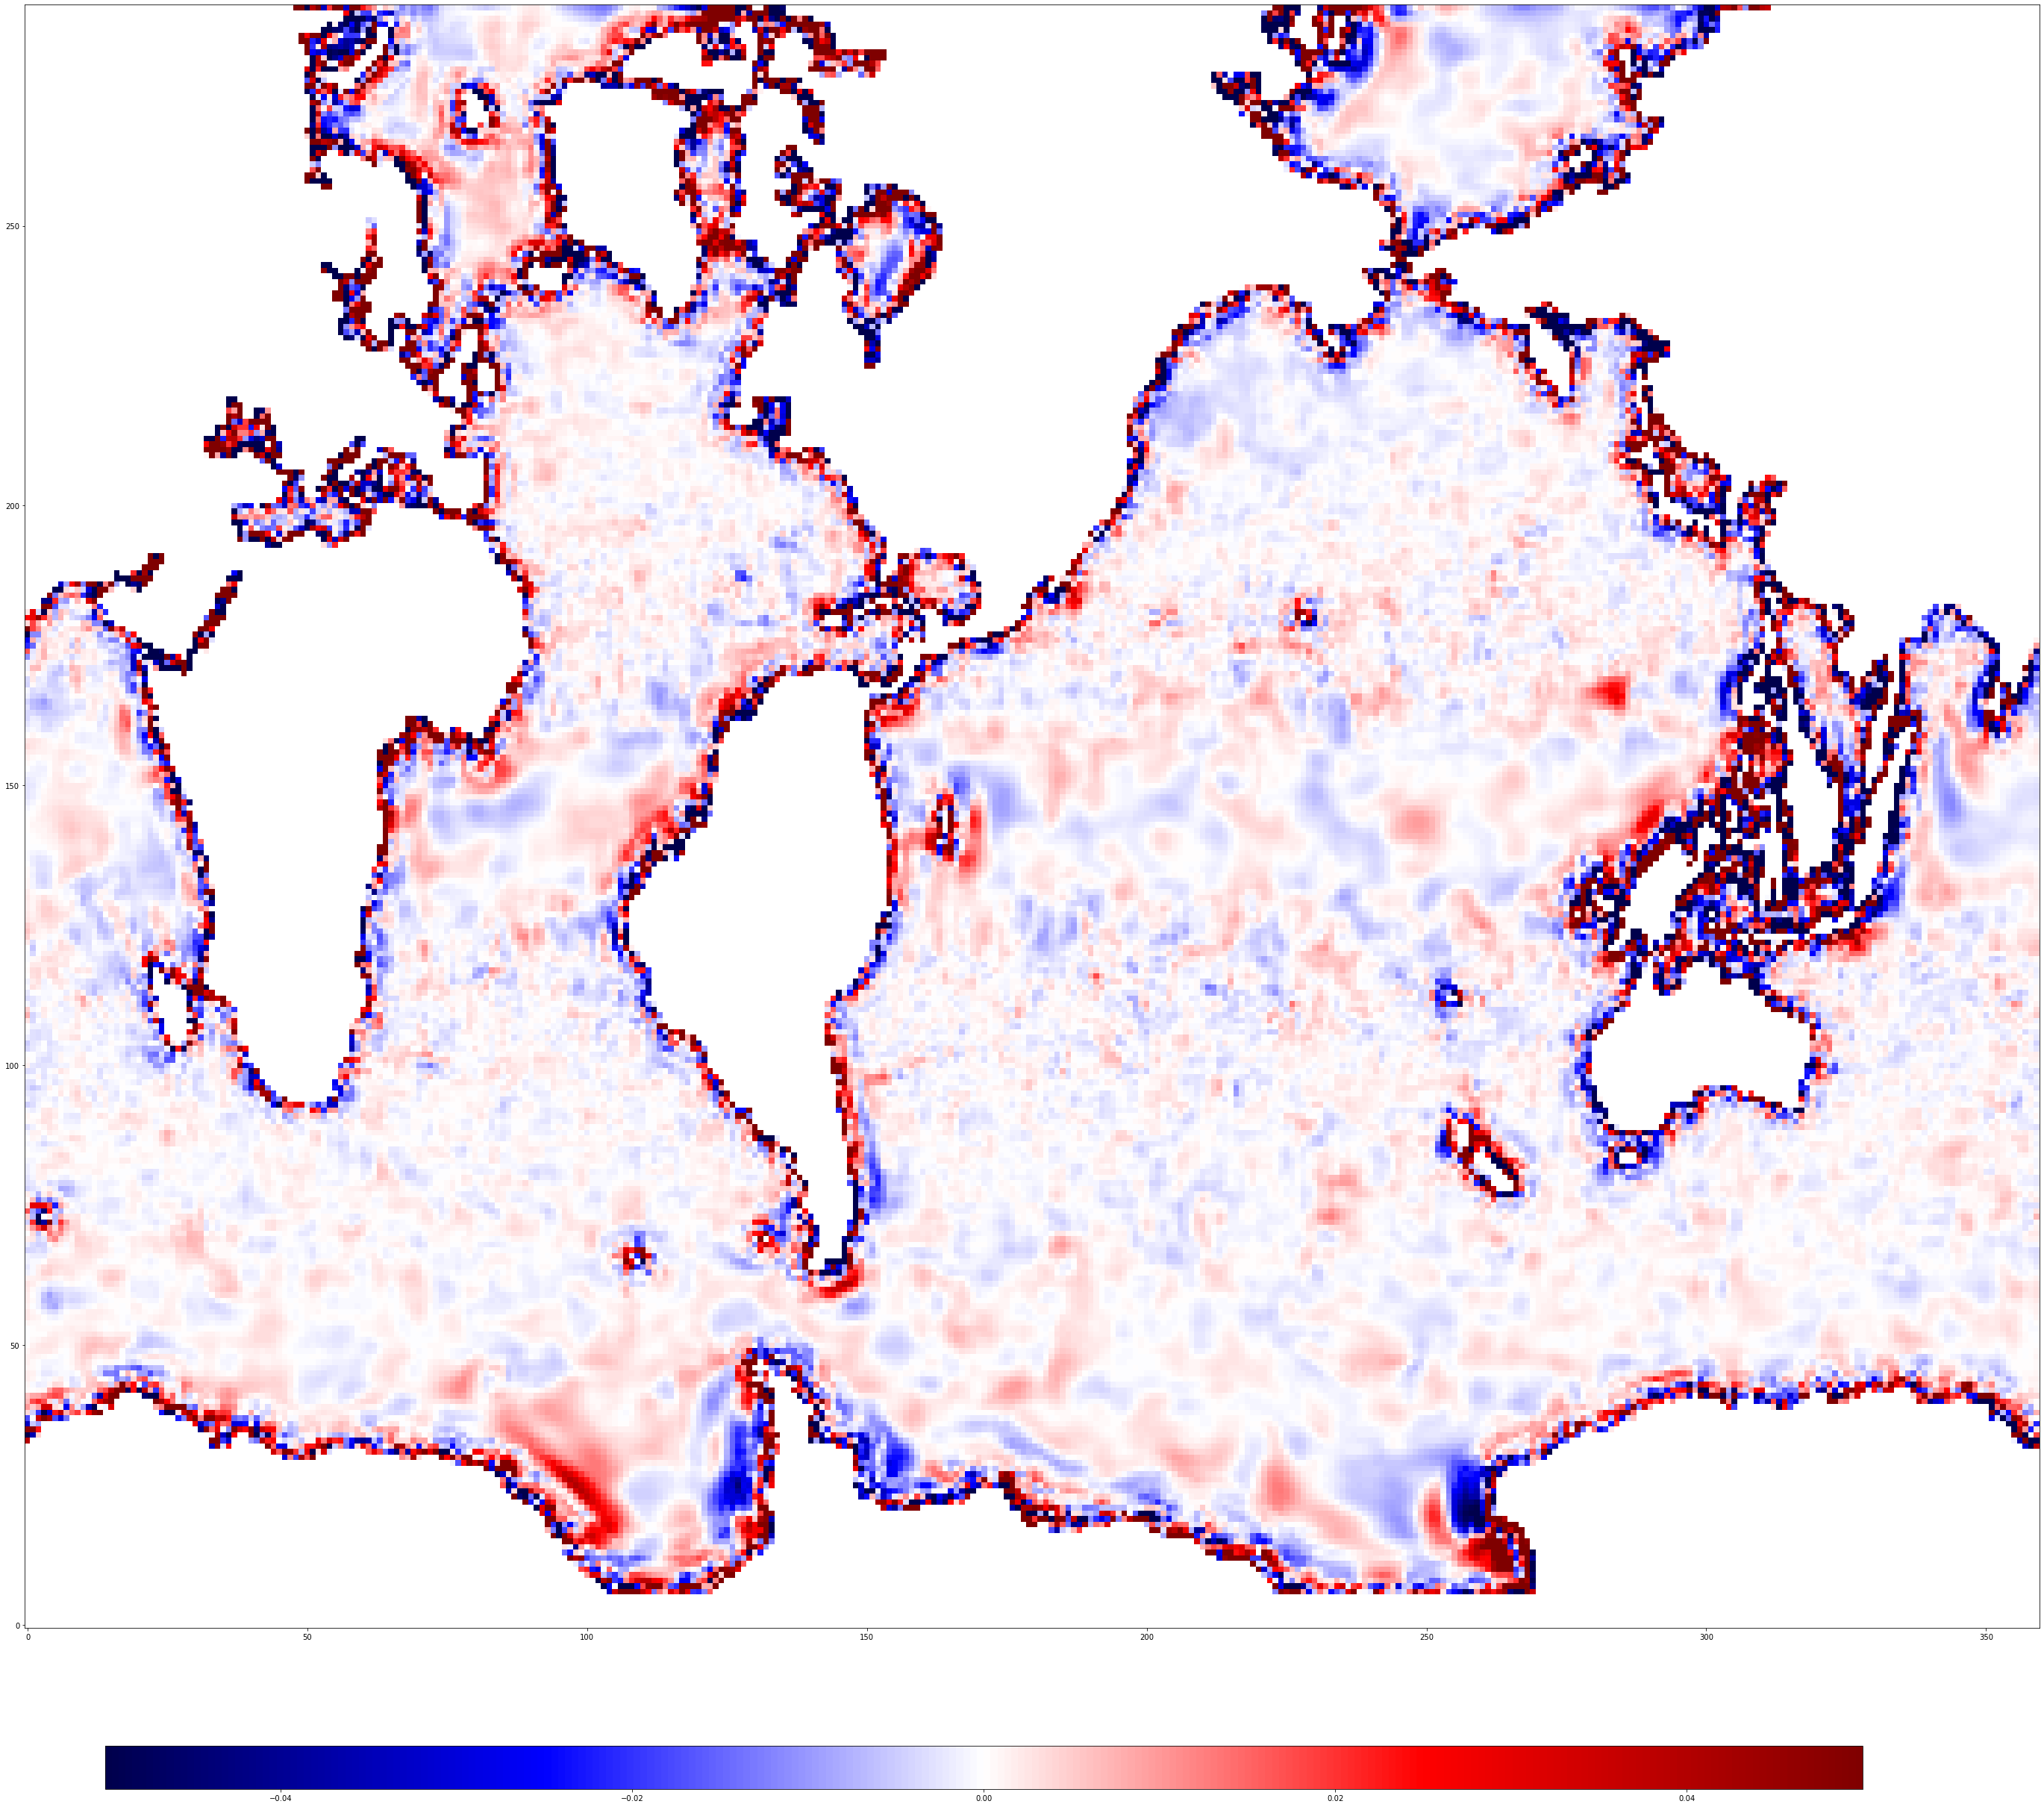

In [384]:
model_path = "results/wandb/cnn/1_1_adam_map/checkpoints/epoch=42198-val_loss=0.00018.ckpt"
X = flip_vert(X_train).copy()
Y = np.fliplr(Y_train).copy()
eps = compute_eps(X,Y,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-0.05,vmax=0.05,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

mean:  0.012670252495447957
max:  1.783403695587458
min:  -0.5756868735795755


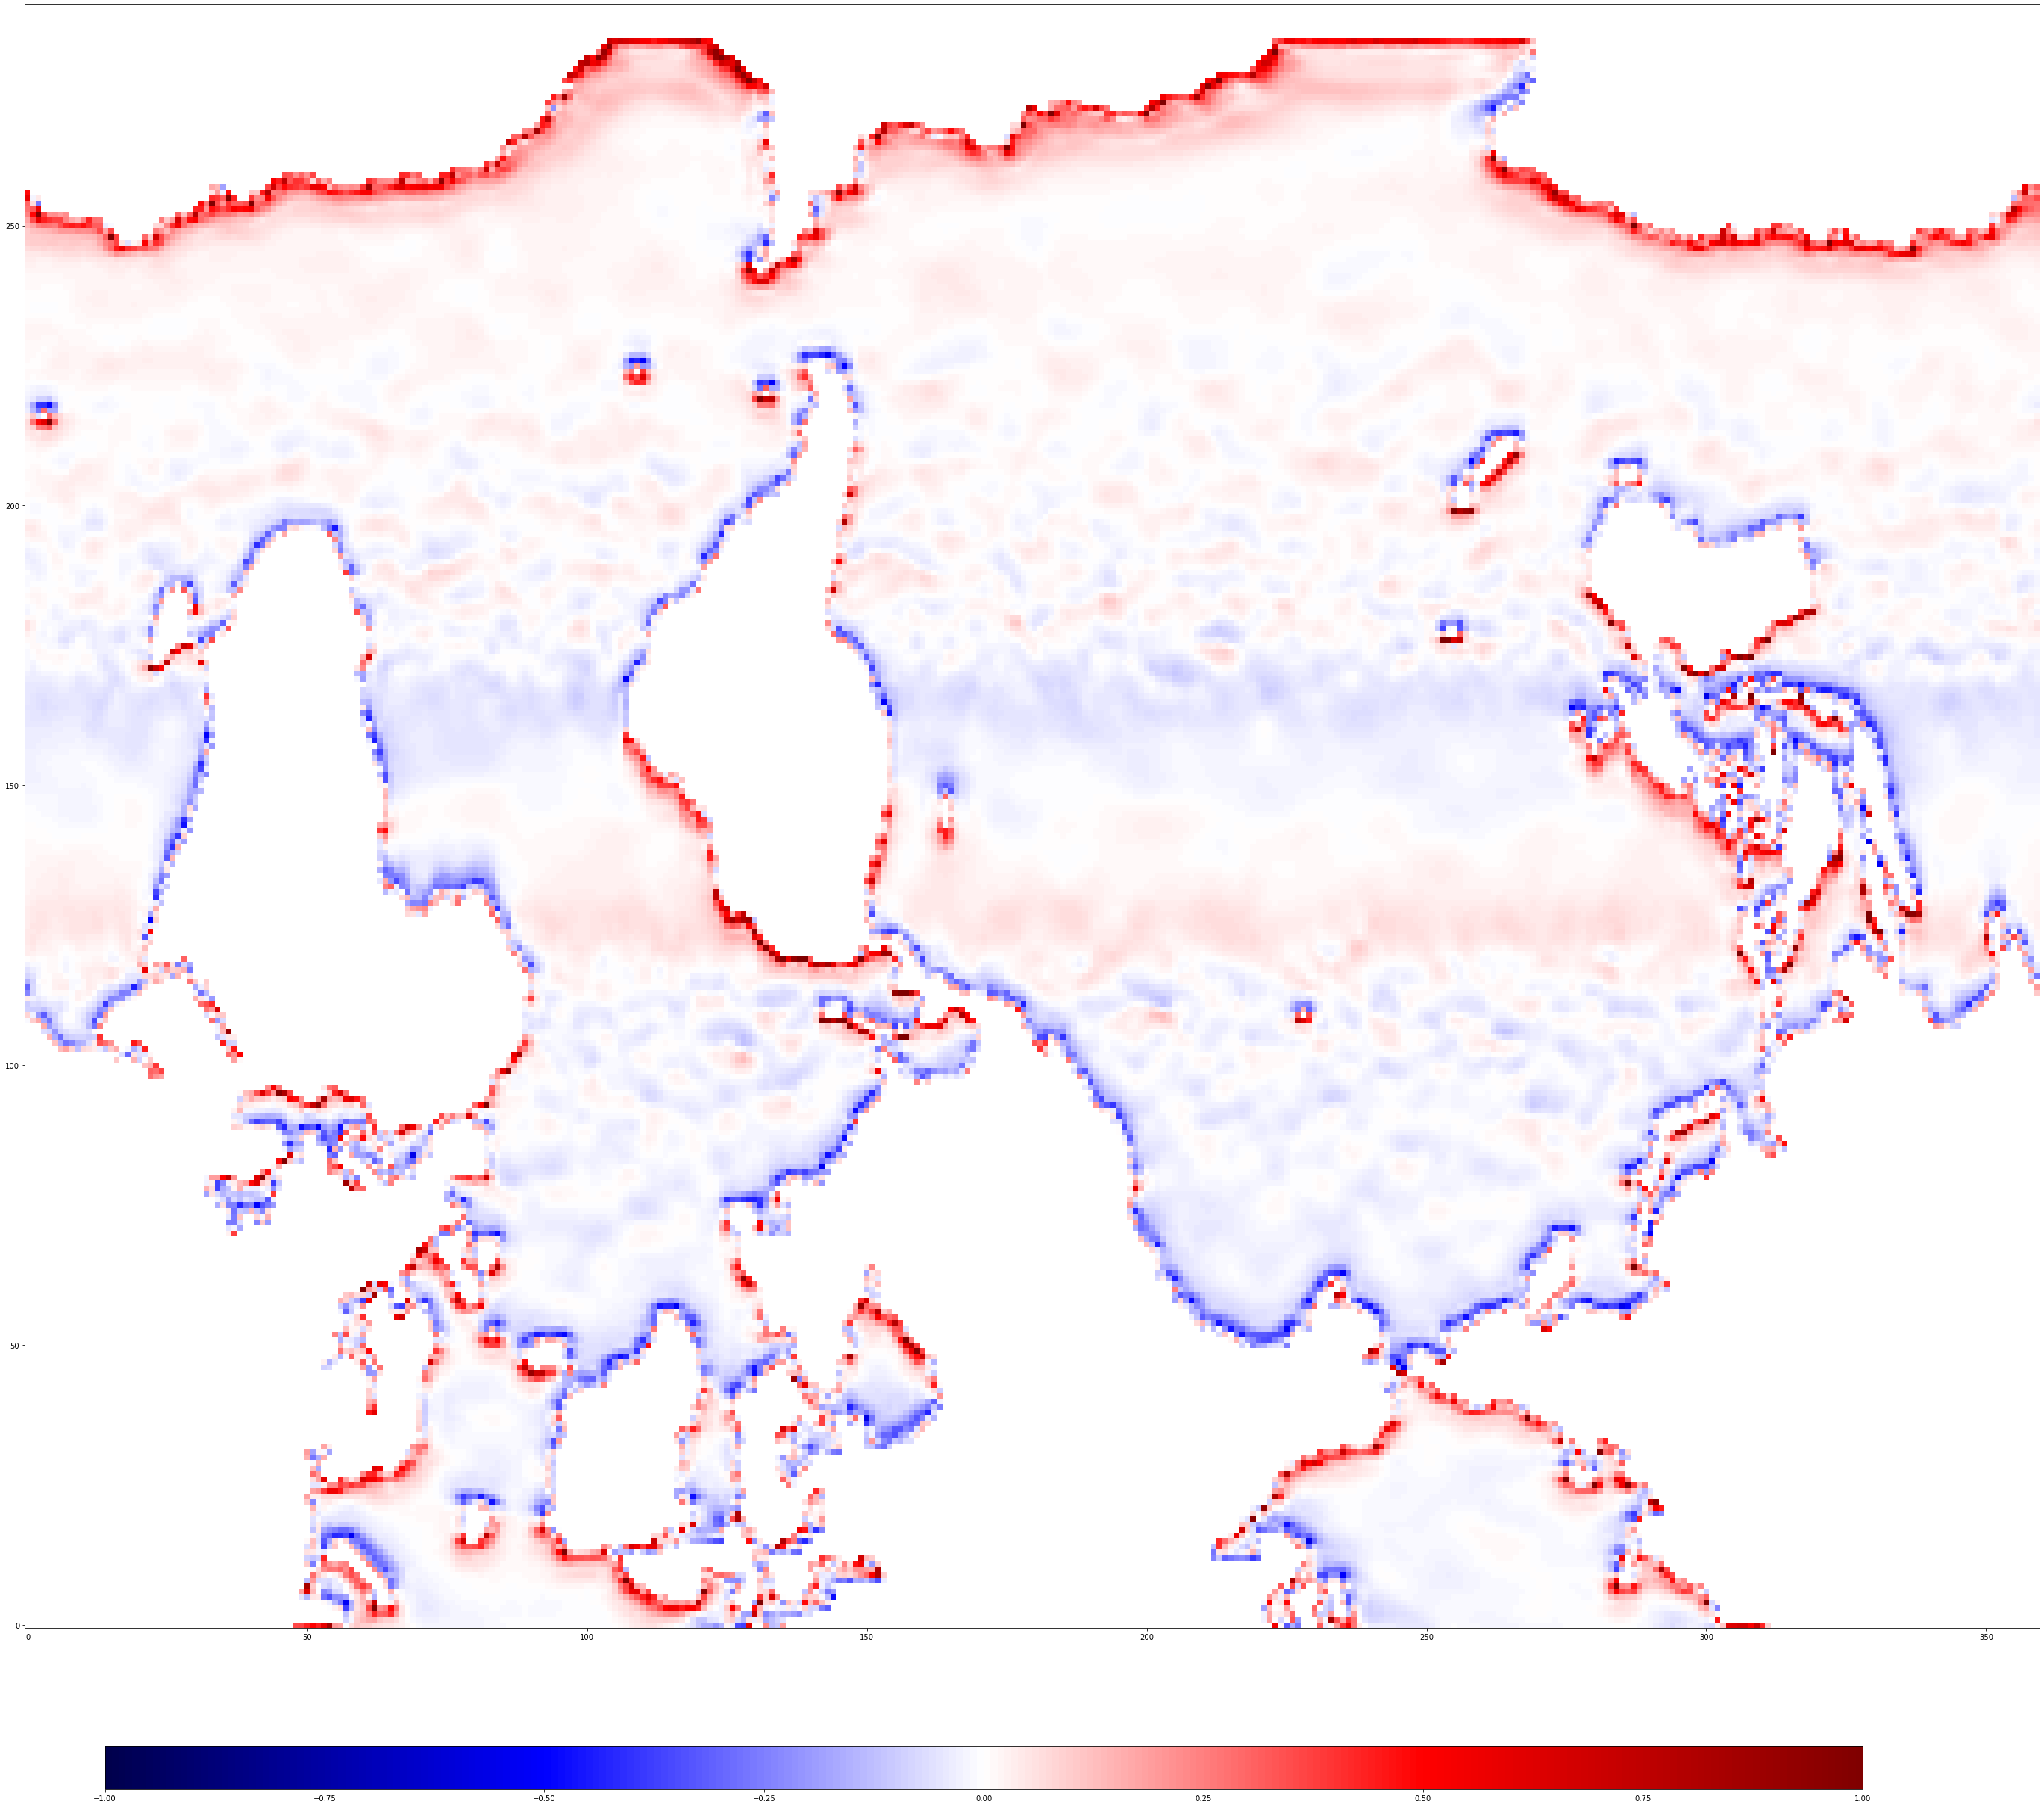

In [40]:
model_path = "results/wandb/cnn/1_1_adam_map/checkpoints/epoch=42198-val_loss=0.00018.ckpt"
X = flip_horV2(flip_vert(X_train)).copy()
Y = np.flipud(np.fliplr(Y_train)).copy()
eps = compute_eps(X,Y,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-1,vmax=1,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

mean:  0.14505326891310963
max:  17.50624689536631
min:  -0.6472507449212915


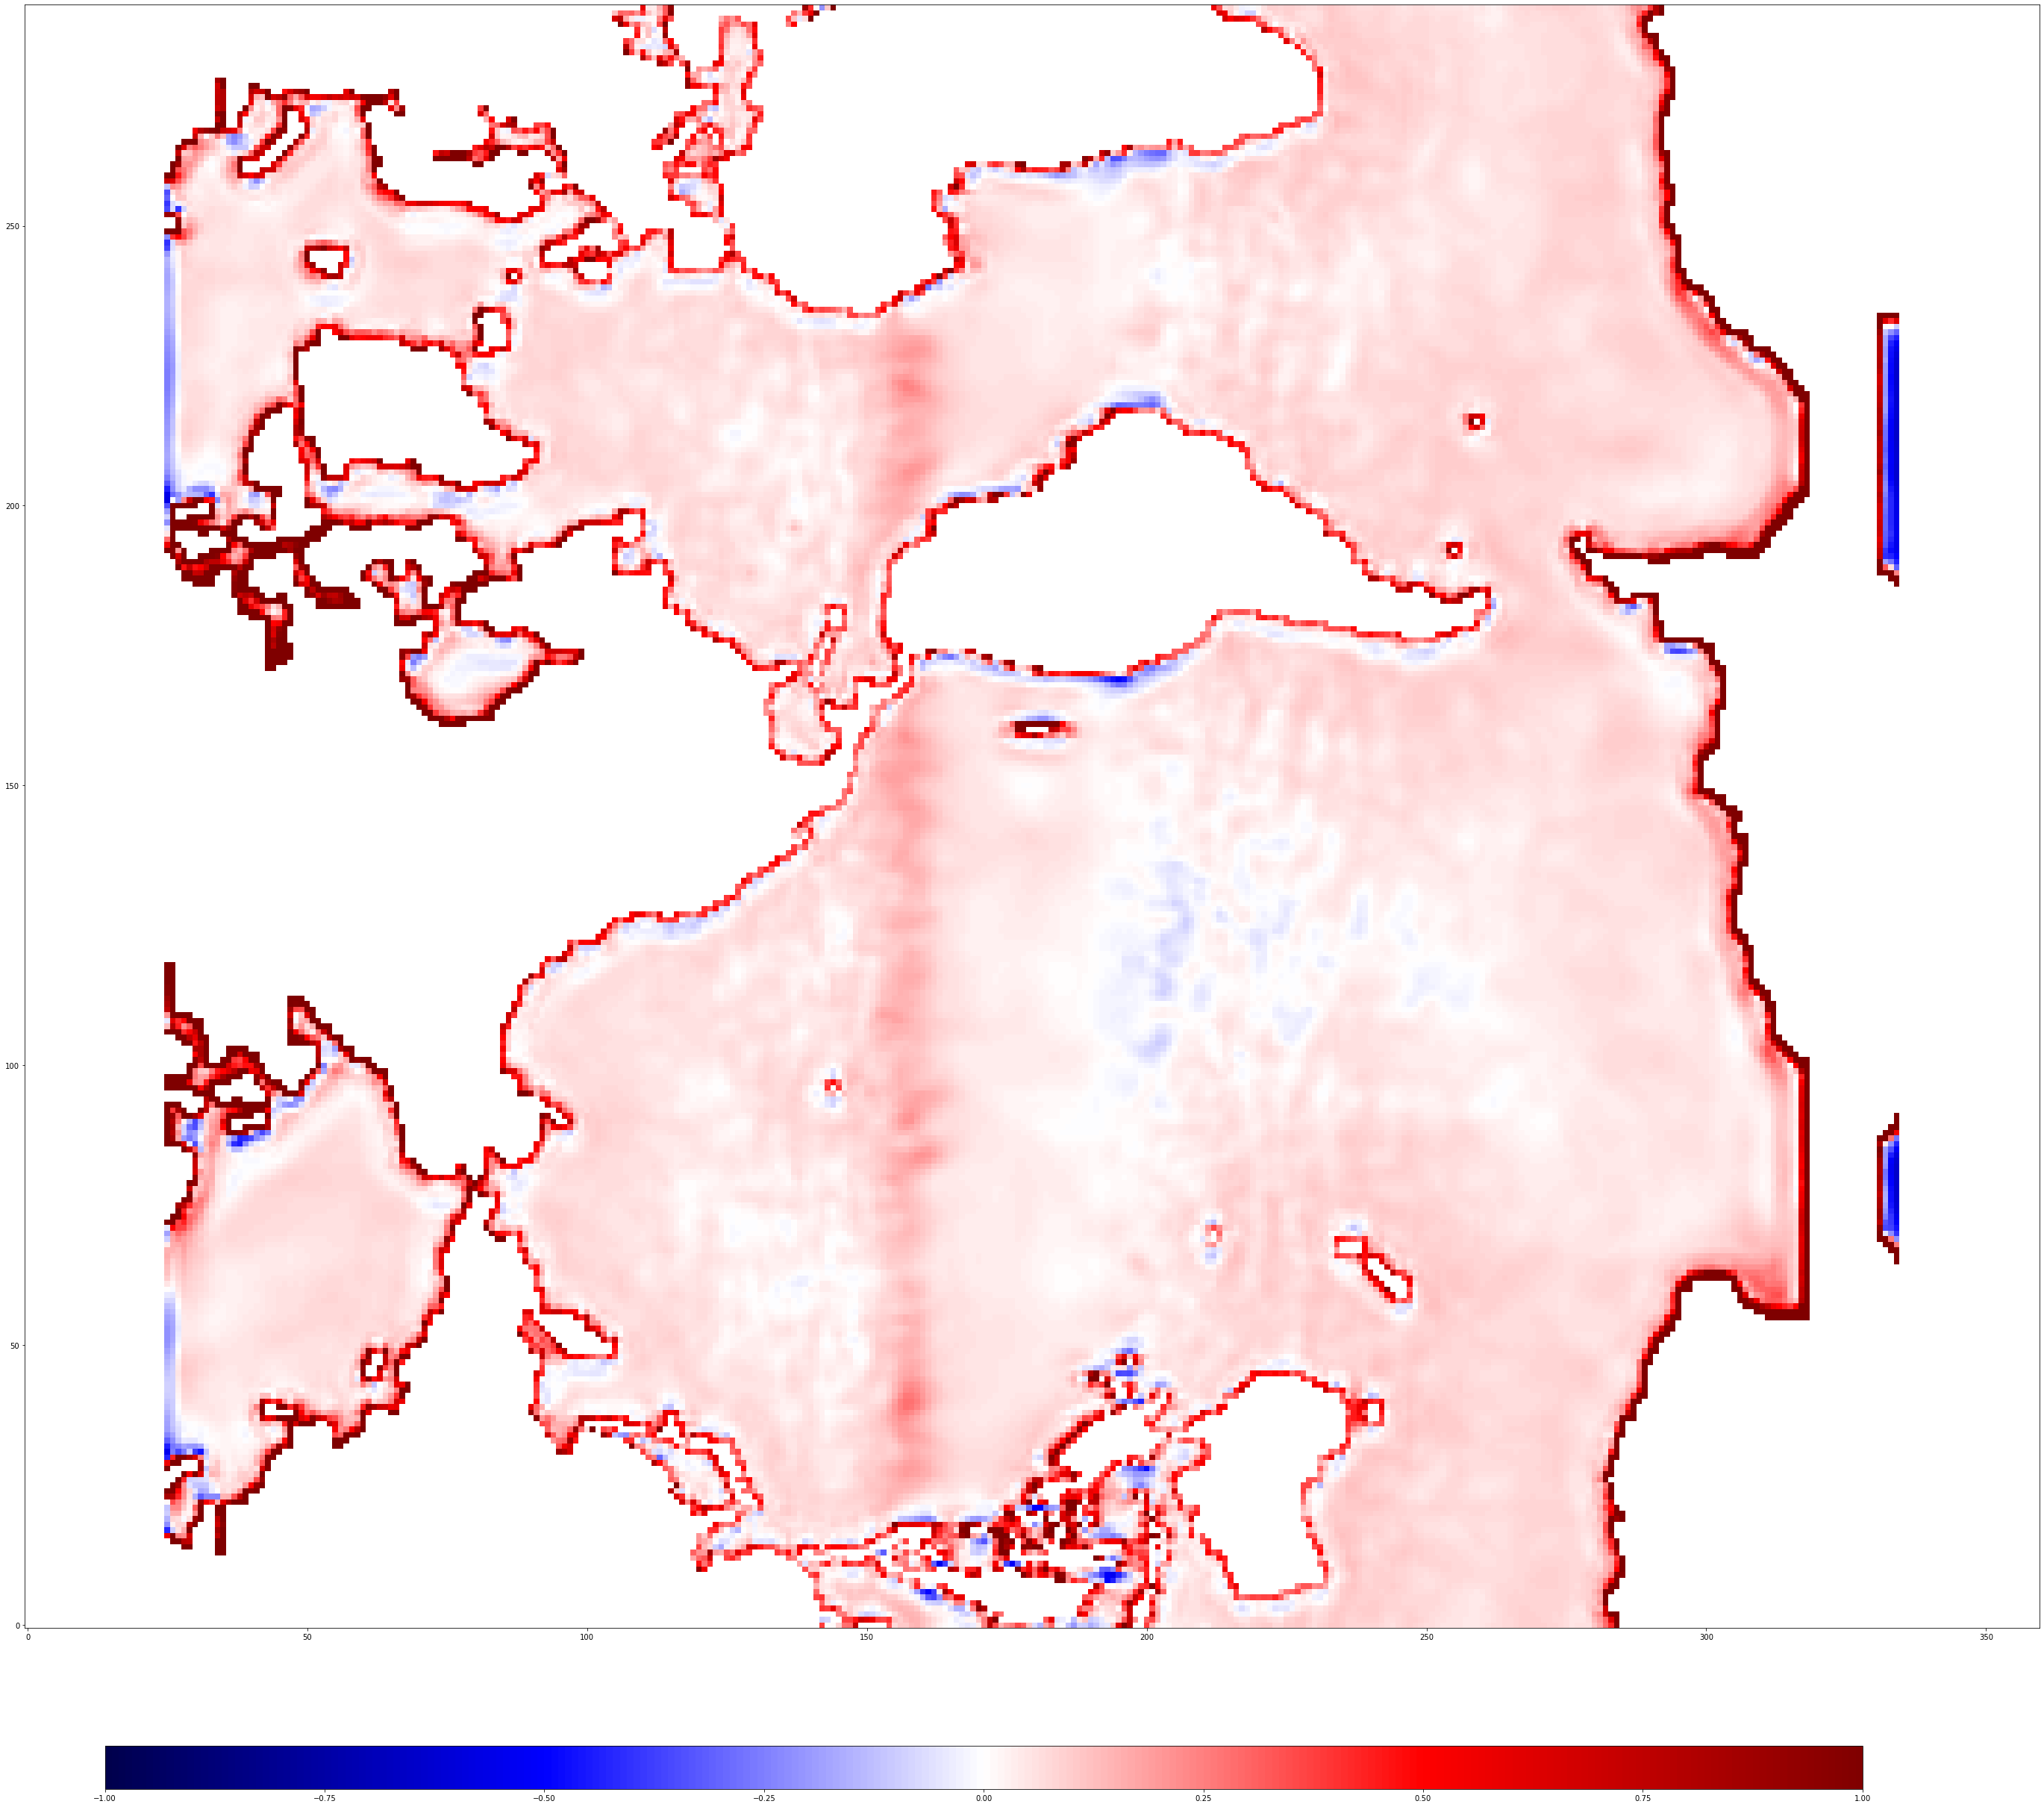

In [356]:
model_path = "results/wandb/cnn/1_1_adam_map/checkpoints/epoch=42198-val_loss=0.00018.ckpt"
X = rota_90(X_train).copy()
Y = np.rot90(Y_train, k=1, axes=(1,0)).copy()
eps = compute_eps(X,Y,model_path,True,distance_map)
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow(eps,origin="lower",vmin=-1,vmax=1,cmap="seismic")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

In [228]:
t = np.array([[j+i for i in range(6)] for j in range(1,36,6)])
print(t)

[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]
 [13 14 15 16 17 18]
 [19 20 21 22 23 24]
 [25 26 27 28 29 30]
 [31 32 33 34 35 36]]


In [240]:
t = np.array([[j+i for i in range(6)] for j in range(1,36,6)])
t = np.rot90(t, k=1, axes=(1,0))
t = np.roll(t, 1, axis = 0)
t = np.rot90(t, k=1, axes=(0,1))
t = np.roll(t, -1, axis = 1)
print(t)
T1 = t

t = np.array([[j+i for i in range(6)] for j in range(1,36,6)])

t = np.fliplr(t)
t = np.roll(t, -1, axis = 1)
t = np.flipud(t)
t = np.roll(t, 1, axis = 0)
print(t)
T2 = t

print(np.array_equal(T1,T2))

[[ 5  4  3  2  1  6]
 [35 34 33 32 31 36]
 [29 28 27 26 25 30]
 [23 22 21 20 19 24]
 [17 16 15 14 13 18]
 [11 10  9  8  7 12]]


In [329]:
def rota_90(X):
    _,H,W  = X.shape
      
    alphas_i = np.rot90(X[0,:,:], k=1, axes=(1,0))
    alphas_j = np.rot90(X[1,:,:], k=1, axes=(1,0))
    w        = np.rot90(X[2,:,:], k=1, axes=(1,0))
    dist_map = np.rot90(X[3,:,:], k=1, axes=(1,0))
    alphas_i = np.roll(alphas_i, -1, axis = 1)
    
    X    = np.empty((4,W,H))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    X[3] = dist_map
    return X

def rota_270(X):
    _,H,W  = X.shape
        
    alphas_i = np.rot90(X[0,:,:], k=1, axes=(0,1))
    alphas_j = np.rot90(X[1,:,:], k=1, axes=(0,1))
    w        = np.rot90(X[2,:,:], k=1, axes=(0,1))
    dist_map = np.rot90(X[3,:,:], k=1, axes=(0,1))
    alphas_j = np.roll(alphas_j, 1, axis = 0)
    
    X    = np.empty((4,W,H))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    X[3] = dist_map
    return X

In [330]:
i = 0
np.array_equal(rota_90(rota_270(X))[i,:,:],rota_270(rota_90(X))[i,:,:])

False

In [428]:
x_90_270 = rota_90(rota_270(X))
x_180 = rota_180(X)

In [387]:
x_90_90.shape, x_180.shape

((4, 310, 380), (4, 310, 380))

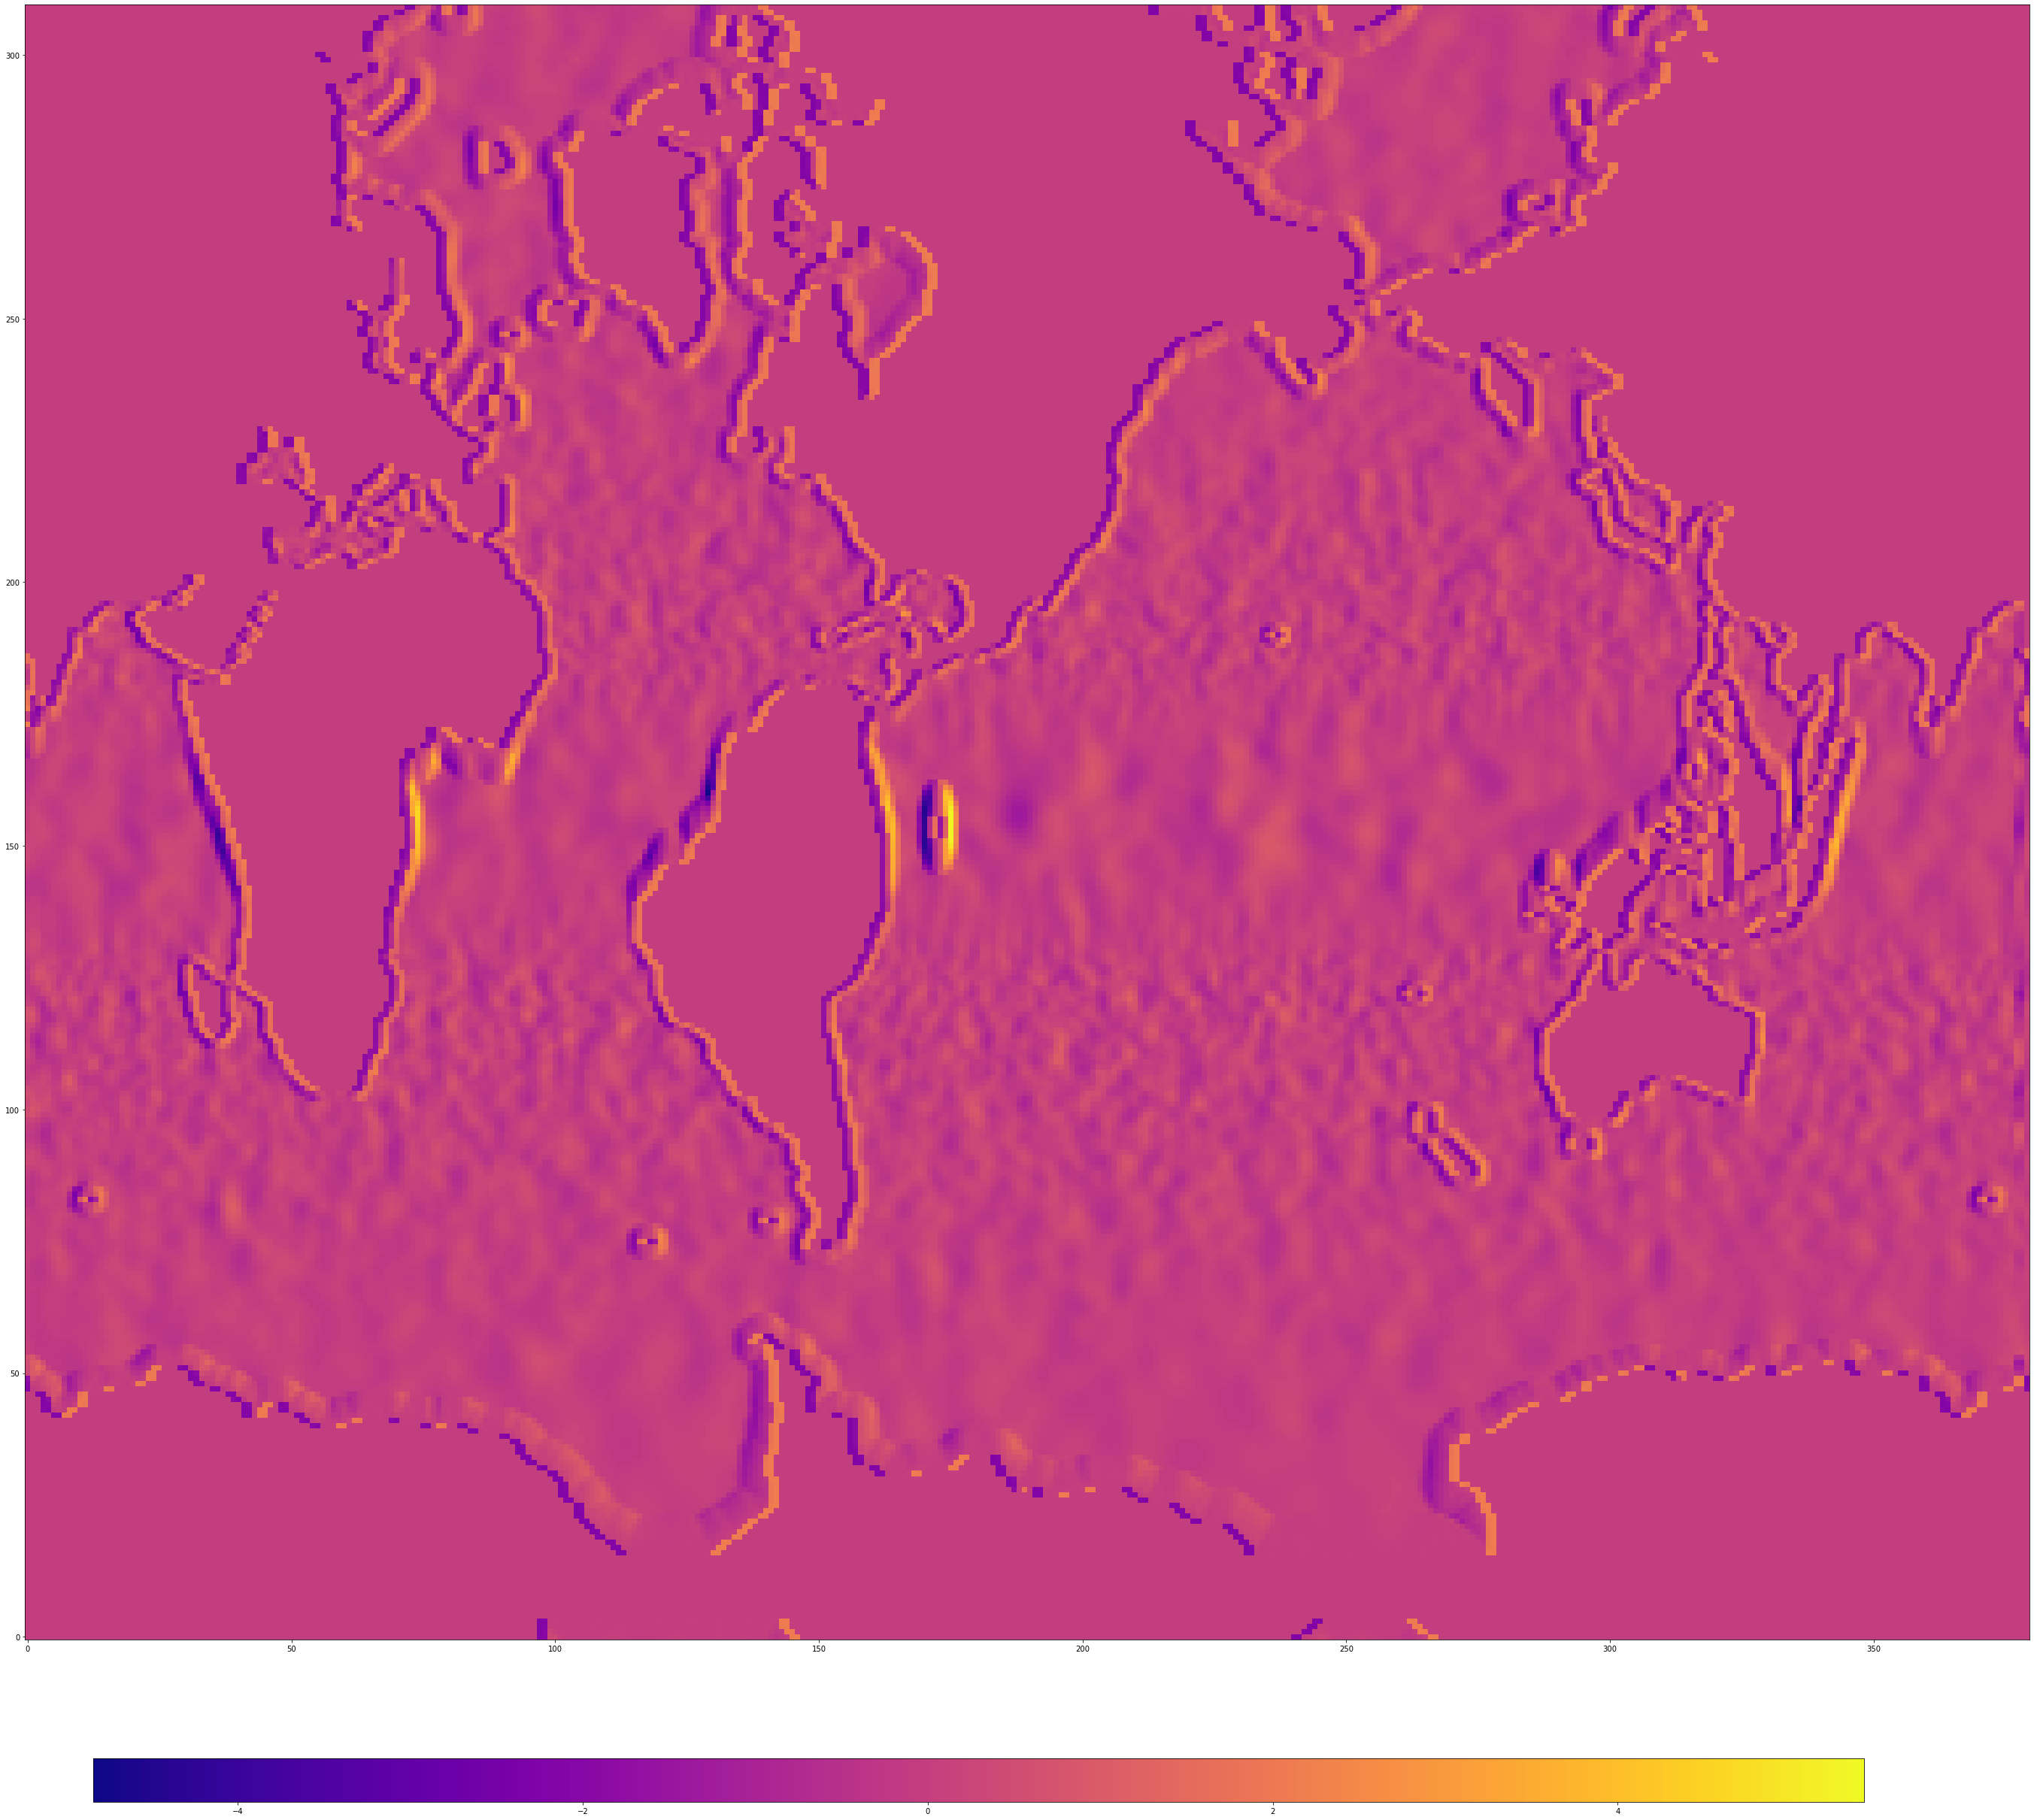

In [435]:
fig,axs = plt.subplots(figsize=size_im,ncols=1)
c = axs.imshow((x_90_270-X)[1,:,:],origin="lower",cmap="plasma")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

In [430]:
np.min((x_90_270-X)[0,:,:])

0.0

In [415]:
t = x_180[0,:,:]
t = np.roll(t, -1,axis = 0)
np.where(x_180==np.max(x_180[0,1:,:])), np.where(t==np.max(t))

((array([0]), array([1]), array([98])), (array([156]), array([40])))

In [65]:
def flip_vert_V2(X):
    _,H,W  = X.shape
    
    
    b = np.append(np.zeros((1,380)), X[0,:,:], axis=0)
    alphas_i = np.flipud(b)
    alphas_j = np.flipud(X[1])
    w        = np.flipud(X[2])
    dist_map = np.flipud(X[3])
    alphas_i = np.roll(alphas_i, 1, axis = 0)
    #X    = np.empty((4,H,W))
    X[0] = alphas_i[1:,:]
    X[1] = alphas_j
    X[2] = w
    X[3] = dist_map
    return X
def flip_vert(X):
    _,H,W  = X.shape

    alphas_i = np.flipud(X[0,:,:])
    alphas_j = np.flipud(X[1,:,:])
    w        = np.flipud(X[2,:,:])
    dist_map = np.flipud(X[3,:,:])
    alphas_i = np.roll(alphas_i, 1, axis = 0)
    X    = np.empty((4,H,W))
    X[0] = alphas_i
    X[1] = alphas_j
    X[2] = w
    X[3] = dist_map
    return X

In [63]:
np.array_equal(flip_vert_V2(flip_vert_V2(X)),X)

True

In [48]:
t = np.array([[i+j for i in range(3)] for j in range(0,9,3)])
print(t)
print()
t2 = np.append(np.zeros((1,3)),t,axis=0)
print(t2)
t2 = np.flipud(t2)
print(t2)
print()
print(t2[:-1,:])

[[0 1 2]
 [3 4 5]
 [6 7 8]]

[[0. 0. 0.]
 [0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[6. 7. 8.]
 [3. 4. 5.]
 [0. 1. 2.]
 [0. 0. 0.]]

[[6. 7. 8.]
 [3. 4. 5.]
 [0. 1. 2.]]
